# Building a Dataset of Features

Now that I know which features I would like to extract to build a model, I will compile them in a single matrix and save to .csv files. 

## 3A Version
In this version, I will incorporate additional audio files that I was able to find on the internet from soundbible and SFXMedia.  Additionally, I will also address the different lengths of sound files differently.  Instead of using librosa.utils.fix_length() to insert zeros as I did previously, I will first decrease the length of the longer audio clips and fill the shorter clips with duplicates of its own features. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
librosa(__version__)

## Firearm Audio Files for Training
The following creates a list with the names of the files of interest:  *.wav, *mp3*, and *.aiff

In [33]:
firearm_path='/Users/aarojas/Documents/Data_Science_Resources/Insight_20B/AAR_Insight_Project/Firearm_Detection/data/raw/Firearms/'
firearm_audio_list=[]
for file in os.listdir(firearm_path):
    if file.endswith('.wav'):
        firearm_audio_list.append(file)
    if file.endswith('.mp3'):
        firearm_audio_list.append(file)
    if file.endswith('.aiff'):
        firearm_audio_list.append(file)
print('The number of audio files are:',len(firearm_audio_list))
print('The number of audio files used for training are ',len(firearm_audio_list[0:int(len(firearm_audio_list)*.7)]))
print('\n')
print('The number of audio files used for testing are ',len(firearm_audio_list[int(len(firearm_audio_list)*.7):]))
firearm_train_files=firearm_audio_list[0:int(len(firearm_audio_list)*.7)]
firearm_test_files=firearm_audio_list[int(len(firearm_audio_list)*.7):]

The number of audio files are: 127
The number of audio files used for training are  88


The number of audio files used for testing are  39


In order to put these files into a model, there must be control on the input sizes.  That is, the array shapes must be uniform for all.  This is difficult because these audio files are not all of the same duration.  Let's see how these sound clips compare.  I will use a function in librosa that allows me to query the duration of each audio clip. 

/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings

Text(0.5, 0, 'Index')

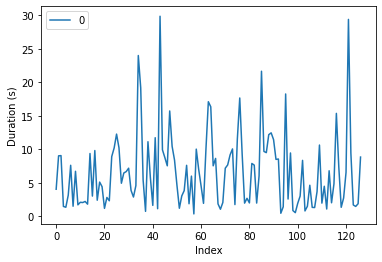

In [3]:
firearm_duration=[]
for audio_file in firearm_audio_list:
    y,sr=librosa.load(firearm_path+audio_file,sr=22050)
    firearm_duration.append(librosa.get_duration(y=y, sr=sr))
firearm_duration=pd.DataFrame(firearm_duration)
firearm_duration.plot()
plt.ylabel('Duration (s)')
plt.xlabel('Index')

In [4]:
firearm_duration.describe()

,0
count,127.000000
mean,6.611860
std,5.656749
min,0.382540
25%,1.996440
50%,5.418458
75%,9.332449
max,29.867256


## Environment Audio Files for Training
I'm going to reduce this dataset by one fourth--to make things run faster for now. I will keep the first half of audio files in each category.

In [5]:
esc50audio_path='/Users/aarojas/Documents/Data_Science_Resources/Insight_20B/AAR_Insight_Project/Firearm_Detection/data/raw/ESC-50-master/audio/'

esc50csv_path='/Users/aarojas/Documents/Data_Science_Resources/Insight_20B/AAR_Insight_Project/Firearm_Detection/data/raw/ESC-50-master/meta/'
esc50=pd.read_csv(esc50csv_path+'esc50.csv',sep=',')

esc50_reduced=[]
esc50_test_files=[]
esc50bycategory=esc50.groupby(['category'])

# Take the first 10 audio files in each category 
for name, group in esc50bycategory:
    esc50_reduced+=list(group['filename'].iloc[0:10])
    esc50_test_files.append(group['filename'].iloc[25])

print(len(esc50_reduced))
print(esc50_reduced[1:5])
print(esc50_test_files[:3])


500
['1-24796-A-47.wav', '1-36929-A-47.wav', '1-43807-A-47.wav', '1-43807-B-47.wav']
['4-161099-B-47.wav', '4-176914-A-23.wav', '4-144468-B-27.wav']


## Helper Function to Obtain Features from Librosa
In the following, I will decrease the duration to 3 seconds. 

In [6]:
def obtainFeatures(audio_path,file,printtxt=False):
    '''
    audio_path is a string to the path of an audio file
    filenames is a list of strings of the names of the files''' 

    y,sr=librosa.load(audio_path+file,duration=3, sr=22050)

    # the MFCC
    mfcc=librosa.feature.mfcc(y)

    # the log Mel Spectrogram
    melspec=librosa.feature.melspectrogram(y)
    log_melspec=librosa.amplitude_to_db(melspec)

    # the HPSS
    y_harmonic,y_percussive=librosa.effects.hpss(y)
    melspec=librosa.feature.melspectrogram(y_harmonic)
    log_harmonic=librosa.amplitude_to_db(melspec)
    melspec=librosa.feature.melspectrogram(y_percussive)
    log_percussive=librosa.amplitude_to_db(melspec)
    
    if printtxt==True:
        print('The shape of mfcc is: ',mfcc.shape)
        print('The shape of log_melspec is :',log_melspec.shape)
        print('The shape of log_percussive is', log_percussive.shape)
        print('The shape of log_harmonic is', log_harmonic.shape)
        print('\n')
    return mfcc,log_melspec,log_harmonic,log_percussive

mfcc,log_melspec,log_harm,log_per=obtainFeatures(esc50audio_path,esc50_reduced[0],printtxt=True)

The shape of mfcc is:  (20, 130)
The shape of log_melspec is : (128, 130)
The shape of log_percussive is (128, 130)
The shape of log_harmonic is (128, 130)




Flatten the matrices of interest

In [7]:
def flattenArray(feature,printtxt=False):
    '''feature is a np.array'''
    feature_flat=feature.reshape((1,len(feature.flatten().T)))
    if printtxt==True:
        print('The shape of the feature is ',feature_flat.shape)
    return feature_flat

mfcc_flat=flattenArray(mfcc,printtxt=True)
log_melspec_flat=flattenArray(log_melspec,printtxt=True)
log_harm_flat=flattenArray(log_harm,printtxt=True)
log_per_flat=flattenArray(log_per,printtxt=True)

The shape of the feature is  (1, 2600)
The shape of the feature is  (1, 16640)
The shape of the feature is  (1, 16640)
The shape of the feature is  (1, 16640)


"Center" the data by substracting the mean and dividing by the standard deviation. 

In [8]:
def centerFeature(feature_flat):
    '''feature_flat is a np.array row vector (1,n)'''
    mean=np.mean(feature_flat)
    std=np.std(feature_flat)
    return (feature_flat-mean)/std

MFCC=centerFeature(mfcc_flat)
LOG_MS=centerFeature(log_melspec_flat)
LOG_H=centerFeature(log_harm_flat)
LOG_P=centerFeature(log_per_flat)

In [9]:
processed_data_path='/Users/aarojas/Documents/Data_Science_Resources/Insight_20B/AAR_Insight_Project/Firearm_Detection/data/processed/'
os.chdir(path=processed_data_path)


## Helper function: combine 

In [10]:
def combine(audio_path,file):
    mfcc,log_melspec,log_harmonic,log_percussive=obtainFeatures(audio_path,file)
    
    mfcc_centered=centerFeature(flattenArray(mfcc))
    log_ms_centered=centerFeature(flattenArray(log_melspec))
    log_h_centered=centerFeature(flattenArray(log_harmonic))
    log_p_centered=centerFeature(flattenArray(log_percussive))
    return mfcc_centered, log_ms_centered, log_h_centered, log_p_centered

## Build the Environmental Sound Dataset
First, I will focus on looking at only the mfcc to build a model. 

In [11]:
for file in esc50_reduced[1:]:
    mfcc_centered,log_ms_centered,log_h_centered,log_p_centered=combine(esc50audio_path,file)
    
    MFCC=np.concatenate((MFCC,mfcc_centered),axis=0)
    LOG_MS=np.concatenate((LOG_MS,log_ms_centered),axis=0)
    LOG_H=np.concatenate((LOG_H,log_h_centered),axis=0)
    LOG_P=np.concatenate((LOG_P,log_p_centered),axis=0)
                         

In [12]:
print(MFCC.shape)
print(LOG_MS.shape)
print(LOG_H.shape)
print(LOG_P.shape)

(500, 2600)
(500, 16640)
(500, 16640)
(500, 16640)


In [13]:
np.savetxt("ESC50_MFCC_train.csv", MFCC, delimiter=",")
np.savetxt("ESC50_logMS_train.csv",LOG_MS,delimiter=",")
np.savetxt("ESC50_logH_train.csv",LOG_H,delimiter=",")
np.savetxt("ESC50_logP_train.csv",LOG_P,delimiter=",")

## Build the Firearms Sound Training Dataset

In [14]:
esc50mfcc_feature_len=MFCC.shape[1]
esc50log_feature_len=LOG_MS.shape[1]

In [ ]:
b=np.array([1,2,3,4])
b.shape
b=np.reshape(b,(1,4))
b.shape
bb=np.tile(b,2)
bb.shape


In [27]:
MFCC_fa,LOG_MS_fa,LOG_H_fa,LOG_P_fa=combine(firearm_path,firearm_audio_list[0])
print('before fixing the length',MFCC_fa.shape,LOG_MS_fa.shape,LOG_H_fa.shape,LOG_P_fa.shape)

def PadMatrix(esc50_feature_len,firearm_feature):
    times=esc50_feature_len/firearm_feature.shape[1]
    if times==1:
        # do nothing, they are the same length
        return firearm_feature
    if times<1:
        # the environmental sound file is shorter than the firearm sound length
        firearm_feature_adjusted=firearm_feature[:,:esc50_feature_len]
        assert (firearm_feature_adjusted.shape == (1, esc50_feature_len))
        return firearm_feature_adjusted
    if times>1: 
        # the environmental sound file is LONGER than the firearm sound length
        whole_times=esc50_feature_len//firearm_feature.shape[1] # returns a whole number 
        remainder=esc50_feature_len-whole_times*firearm_feature.shape[1]
        first=np.tile(firearm_feature,whole_times)
        second=firearm_feature[0,:remainder]
        third=np.reshape(second,(1,len(second)))
        firearm_feature_adjusted=np.concatenate((first,third),axis=1)
        assert (firearm_feature_adjusted.shape == (1, esc50_feature_len))
        return firearm_feature_adjusted
    return 'No condition met.'
# ensure that the firearms dataset is the same length as that of the non-firearm
#MFCC_fa=librosa.util.fix_length(MFCC_fa,mfcc_centered.shape[1])
#LOG_MS_fa=librosa.util.fix_length(LOG_MS_fa,LOG_MS.shape[1])
#LOG_H_fa=librosa.util.fix_length(LOG_H_fa,LOG_H.shape[1])
#LOG_P_fa=librosa.util.fix_length(LOG_P_fa,LOG_P.shape[1])

MFCC_fa=PadMatrix(esc50mfcc_feature_len,MFCC_fa)
LOG_MS_fa=PadMatrix(esc50log_feature_len,LOG_MS_fa)
LOG_H_fa=PadMatrix(esc50log_feature_len,LOG_H_fa)
LOG_P_fa=PadMatrix(esc50log_feature_len,LOG_P_fa)
print('after fixing the length',MFCC_fa.shape, LOG_MS_fa.shape,LOG_H_fa.shape,LOG_P_fa.shape)



/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


before fixing the length (1, 2600) (1, 16640) (1, 16640) (1, 16640)
after fixing the length (1, 2600) (1, 16640) (1, 16640) (1, 16640)


In [20]:
for file in firearm_train_files:
    mfcc_centered,log_ms_centered,log_h_centered,log_p_centered=combine(firearm_path,file)
    
    mfcc_centered=PadMatrix(esc50mfcc_feature_len,mfcc_centered)
    log_ms_centered=PadMatrix(esc50log_feature_len,log_ms_centered)
    log_h_centered=PadMatrix(esc50log_feature_len,log_h_centered)
    log_p_centered=PadMatrix(esc50log_feature_len,log_p_centered)
    
    MFCC_fa=np.concatenate((MFCC_fa,mfcc_centered),axis=0)
    LOG_MS_fa=np.concatenate((LOG_MS_fa,log_ms_centered),axis=0)
    LOG_H_fa=np.concatenate((LOG_H_fa,log_h_centered),axis=0)
    LOG_P_fa=np.concatenate((LOG_P_fa,log_p_centered),axis=0)

/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


whole times= 2
The remainder: 0
(1, 2600)
(1, 0)
(1, 1300)
whole times= 2
The remainder: 0
(1, 16640)
(1, 0)
(1, 8320)
whole times= 2
The remainder: 0
(1, 16640)
(1, 0)
(1, 8320)
whole times= 2
The remainder: 0
(1, 16640)
(1, 0)
(1, 8320)
whole times= 2
The remainder: 200
(1, 2400)
(1, 200)
(1, 1200)
whole times= 2
The remainder: 1280
(1, 15360)
(1, 1280)
(1, 7680)
whole times= 2
The remainder: 1280
(1, 15360)
(1, 1280)
(1, 7680)
whole times= 2
The remainder: 1280
(1, 15360)
(1, 1280)
(1, 7680)
whole times= 1
The remainder: 1280
(1, 1320)
(1, 1280)
(1, 1320)
whole times= 1
The remainder: 8192
(1, 8448)
(1, 8192)
(1, 8448)
whole times= 1
The remainder: 8192
(1, 8448)
(1, 8192)
(1, 8448)
whole times= 1
The remainder: 8192
(1, 8448)
(1, 8192)
(1, 8448)


/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


whole times= 1
The remainder: 1100
(1, 1500)
(1, 1100)
(1, 1500)
whole times= 1
The remainder: 7040
(1, 9600)
(1, 7040)
(1, 9600)
whole times= 1
The remainder: 7040
(1, 9600)
(1, 7040)
(1, 9600)
whole times= 1
The remainder: 7040
(1, 9600)
(1, 7040)
(1, 9600)
whole times= 1
The remainder: 760
(1, 1840)
(1, 760)
(1, 1840)
whole times= 1
The remainder: 4864
(1, 11776)
(1, 4864)
(1, 11776)
whole times= 1
The remainder: 4864
(1, 11776)
(1, 4864)
(1, 11776)
whole times= 1
The remainder: 4864
(1, 11776)
(1, 4864)
(1, 11776)
whole times= 1
The remainder: 800
(1, 1800)
(1, 800)
(1, 1800)
whole times= 1
The remainder: 5120
(1, 11520)
(1, 5120)
(1, 11520)
whole times= 1
The remainder: 5120
(1, 11520)
(1, 5120)
(1, 11520)
whole times= 1
The remainder: 5120
(1, 11520)
(1, 5120)
(1, 11520)
whole times= 1
The remainder: 660
(1, 1940)
(1, 660)
(1, 1940)
whole times= 1
The remainder: 4224
(1, 12416)
(1, 4224)
(1, 12416)
whole times= 1
The remainder: 4224
(1, 12416)
(1, 4224)
(1, 12416)
whole times= 1


/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


whole times= 1
The remainder: 500
(1, 2100)
(1, 500)
(1, 2100)
whole times= 1
The remainder: 3200
(1, 13440)
(1, 3200)
(1, 13440)
whole times= 1
The remainder: 3200
(1, 13440)
(1, 3200)
(1, 13440)
whole times= 1
The remainder: 3200
(1, 13440)
(1, 3200)
(1, 13440)


/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


whole times= 2
The remainder: 480
(1, 2120)
(1, 480)
(1, 1060)
whole times= 2
The remainder: 3072
(1, 13568)
(1, 3072)
(1, 6784)
whole times= 2
The remainder: 3072
(1, 13568)
(1, 3072)
(1, 6784)
whole times= 2
The remainder: 3072
(1, 13568)
(1, 3072)
(1, 6784)
whole times= 1
The remainder: 140
(1, 2460)
(1, 140)
(1, 2460)
whole times= 1
The remainder: 896
(1, 15744)
(1, 896)
(1, 15744)
whole times= 1
The remainder: 896
(1, 15744)
(1, 896)
(1, 15744)
whole times= 1
The remainder: 896
(1, 15744)
(1, 896)
(1, 15744)
whole times= 1
The remainder: 580
(1, 2020)
(1, 580)
(1, 2020)
whole times= 1
The remainder: 3712
(1, 12928)
(1, 3712)
(1, 12928)
whole times= 1
The remainder: 3712
(1, 12928)
(1, 3712)
(1, 12928)
whole times= 1
The remainder: 3712
(1, 12928)
(1, 3712)
(1, 12928)


/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


whole times= 1
The remainder: 80
(1, 2520)
(1, 80)
(1, 2520)
whole times= 1
The remainder: 512
(1, 16128)
(1, 512)
(1, 16128)
whole times= 1
The remainder: 512
(1, 16128)
(1, 512)
(1, 16128)
whole times= 1
The remainder: 512
(1, 16128)
(1, 512)
(1, 16128)
whole times= 3
The remainder: 620
(1, 1980)
(1, 620)
(1, 660)
whole times= 3
The remainder: 3968
(1, 12672)
(1, 3968)
(1, 4224)
whole times= 3
The remainder: 3968
(1, 12672)
(1, 3968)
(1, 4224)
whole times= 3
The remainder: 3968
(1, 12672)
(1, 3968)
(1, 4224)
whole times= 1
The remainder: 1160
(1, 1440)
(1, 1160)
(1, 1440)
whole times= 1
The remainder: 7424
(1, 9216)
(1, 7424)
(1, 9216)
whole times= 1
The remainder: 7424
(1, 9216)
(1, 7424)
(1, 9216)
whole times= 1
The remainder: 7424
(1, 9216)
(1, 7424)
(1, 9216)
whole times= 2
The remainder: 600
(1, 2000)
(1, 600)
(1, 1000)
whole times= 2
The remainder: 3840
(1, 12800)
(1, 3840)
(1, 6400)
whole times= 2
The remainder: 3840
(1, 12800)
(1, 3840)
(1, 6400)
whole times= 2
The remainder:

/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


whole times= 1
The remainder: 960
(1, 1640)
(1, 960)
(1, 1640)
whole times= 1
The remainder: 6144
(1, 10496)
(1, 6144)
(1, 10496)
whole times= 1
The remainder: 6144
(1, 10496)
(1, 6144)
(1, 10496)
whole times= 1
The remainder: 6144
(1, 10496)
(1, 6144)
(1, 10496)
whole times= 7
The remainder: 220
(1, 2380)
(1, 220)
(1, 340)
whole times= 7
The remainder: 1408
(1, 15232)
(1, 1408)
(1, 2176)
whole times= 7
The remainder: 1408
(1, 15232)
(1, 1408)
(1, 2176)
whole times= 7
The remainder: 1408
(1, 15232)
(1, 1408)
(1, 2176)
whole times= 1
The remainder: 900
(1, 1700)
(1, 900)
(1, 1700)
whole times= 1
The remainder: 5760
(1, 10880)
(1, 5760)
(1, 10880)
whole times= 1
The remainder: 5760
(1, 10880)
(1, 5760)
(1, 10880)
whole times= 1
The remainder: 5760
(1, 10880)
(1, 5760)
(1, 10880)


/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


whole times= 1
The remainder: 960
(1, 1640)
(1, 960)
(1, 1640)
whole times= 1
The remainder: 6144
(1, 10496)
(1, 6144)
(1, 10496)
whole times= 1
The remainder: 6144
(1, 10496)
(1, 6144)
(1, 10496)
whole times= 1
The remainder: 6144
(1, 10496)
(1, 6144)
(1, 10496)
whole times= 2
The remainder: 720
(1, 1880)
(1, 720)
(1, 940)
whole times= 2
The remainder: 4608
(1, 12032)
(1, 4608)
(1, 6016)
whole times= 2
The remainder: 4608
(1, 12032)
(1, 4608)
(1, 6016)
whole times= 2
The remainder: 4608
(1, 12032)
(1, 4608)
(1, 6016)
whole times= 1
The remainder: 780
(1, 1820)
(1, 780)
(1, 1820)
whole times= 1
The remainder: 4992
(1, 11648)
(1, 4992)
(1, 11648)
whole times= 1
The remainder: 4992
(1, 11648)
(1, 4992)
(1, 11648)
whole times= 1
The remainder: 4992
(1, 11648)
(1, 4992)
(1, 11648)


/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


whole times= 1
The remainder: 1060
(1, 1540)
(1, 1060)
(1, 1540)
whole times= 1
The remainder: 6784
(1, 9856)
(1, 6784)
(1, 9856)
whole times= 1
The remainder: 6784
(1, 9856)
(1, 6784)
(1, 9856)
whole times= 1
The remainder: 6784
(1, 9856)
(1, 6784)
(1, 9856)
whole times= 1
The remainder: 880
(1, 1720)
(1, 880)
(1, 1720)
whole times= 1
The remainder: 5632
(1, 11008)
(1, 5632)
(1, 11008)
whole times= 1
The remainder: 5632
(1, 11008)
(1, 5632)
(1, 11008)
whole times= 1
The remainder: 5632
(1, 11008)
(1, 5632)
(1, 11008)
whole times= 1
The remainder: 260
(1, 2340)
(1, 260)
(1, 2340)
whole times= 1
The remainder: 1664
(1, 14976)
(1, 1664)
(1, 14976)
whole times= 1
The remainder: 1664
(1, 14976)
(1, 1664)
(1, 14976)
whole times= 1
The remainder: 1664
(1, 14976)
(1, 1664)
(1, 14976)
whole times= 1
The remainder: 840
(1, 1760)
(1, 840)
(1, 1760)
whole times= 1
The remainder: 5376
(1, 11264)
(1, 5376)
(1, 11264)
whole times= 1
The remainder: 5376
(1, 11264)
(1, 5376)
(1, 11264)
whole times= 1


In [21]:
print(MFCC_fa.shape)
print(LOG_MS_fa.shape)
print(LOG_H_fa.shape)
print(LOG_P_fa.shape)

(89, 2600)
(89, 16640)
(89, 16640)
(89, 16640)


In [22]:
np.savetxt("firearm_MFCC_train.csv", MFCC_fa, delimiter=",")
np.savetxt("firearm_logMS_train.csv",LOG_MS_fa,delimiter=",")
np.savetxt("firearm_logH_train.csv",LOG_H_fa,delimiter=",")
np.savetxt("firearm_logP_train.csv",LOG_P_fa,delimiter=",")

## Build the Test Sets

In [34]:
MFCC_fa,LOG_MS_fa,LOG_H_fa,LOG_P_fa=combine(firearm_path,firearm_test_files[0])

MFCC_fa=PadMatrix(esc50mfcc_feature_len,MFCC_fa)
LOG_MS_fa=PadMatrix(esc50log_feature_len,LOG_MS_fa)
LOG_H_fa=PadMatrix(esc50log_feature_len,LOG_H_fa)
LOG_P_fa=PadMatrix(esc50log_feature_len,LOG_P_fa)

for file in firearm_test_files[1:]:
    mfcc_centered,log_ms_centered,log_h_centered,log_p_centered=combine(firearm_path,file)
    
    #fix the length
    mfcc_centered=PadMatrix(esc50mfcc_feature_len,mfcc_centered)
    log_ms_centered=PadMatrix(esc50log_feature_len,log_ms_centered)
    log_h_centered=PadMatrix(esc50log_feature_len,log_h_centered)
    log_p_centered=PadMatrix(esc50log_feature_len,log_p_centered)
    
    MFCC_fa=np.concatenate((MFCC_fa,mfcc_centered),axis=0)
    LOG_MS_fa=np.concatenate((LOG_MS_fa,log_ms_centered),axis=0)
    LOG_H_fa=np.concatenate((LOG_H_fa,log_h_centered),axis=0)
    LOG_P_fa=np.concatenate((LOG_P_fa,log_p_centered),axis=0)
    

np.savetxt("firearm_MFCC_test.csv", MFCC_fa, delimiter=",")
np.savetxt("firearm_logMS_test.csv",LOG_MS_fa,delimiter=",")
np.savetxt("firearm_logH_test.csv",LOG_H_fa,delimiter=",")
np.savetxt("firearm_logP_test.csv",LOG_P_fa,delimiter=",")

/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings

In [35]:
print(MFCC_fa.shape)
print(LOG_MS_fa.shape)
print(LOG_H_fa.shape)
print(LOG_P_fa.shape)

(39, 2600)
(39, 16640)
(39, 16640)
(39, 16640)


In [24]:
MFCC,LOG_MS,LOG_H,LOG_P=combine(esc50audio_path,esc50_test_files[0])

for file in esc50_test_files[1:]:
    mfcc,log_melspec,log_harmonic,log_percussive=combine(esc50audio_path,file)
    
    MFCC=np.concatenate((MFCC,mfcc_centered),axis=0)
    LOG_MS=np.concatenate((LOG_MS,log_ms_centered),axis=0)
    LOG_H=np.concatenate((LOG_H,log_h_centered),axis=0)
    LOG_P=np.concatenate((LOG_P,log_p_centered),axis=0)
    
np.savetxt("ESC50_MFCC_test.csv", MFCC, delimiter=",")
np.savetxt("ESC50_logMS_test.csv",LOG_MS,delimiter=",")
np.savetxt("ESC50_logH_test.csv",LOG_H,delimiter=",")
np.savetxt("ESC50_logP_test.csv",LOG_P,delimiter=",")

/opt/anaconda3/envs/add_librosa/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
